In [13]:
from image_data import ImageData
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
imageData = ImageData(None, fname=r"C:\code\astrocam\images\20250825\M 57 NGC 6720\Light\Light_00793_10.0sec_200gain_0.0C.fit", header={})


In [14]:
img = imageData.deb16
red, _ = np.histogram(img[:,:,0], bins=256, range=(0, 65536))
green, _ = np.histogram(img[:,:,1], bins=256, range=(0, 65536))
blue, _ = np.histogram(img[:,:,2], bins=256, range=(0, 65536))

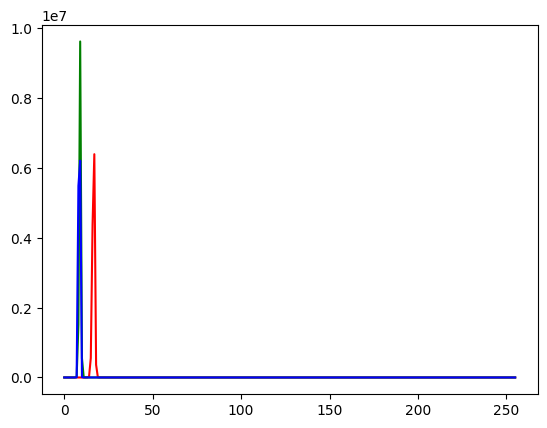

In [15]:
plt.plot(red, color='red')
plt.plot(green, color='green')
plt.plot(blue, color='blue')

In [76]:
def fit_1dgausssian(arr):
    # Find maximum value of array
    max_val = np.max(arr)
    
    # Find index of maximum value
    max_index = np.argmax(arr)
    
    # Define Gaussian function
    def gaussian(x, amplitude, mean, stddev, offset=0):
        return offset + amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
    
    # Define error function
    def errfunc(p, x, y):
        return gaussian(x, *p) - y
    
    # Define x and y values for curve_fit
    x = np.arange(len(arr))
    y = arr
    
    half_max = max_val / 2
    indices_half_max = np.where(y >= half_max)[0]
    if len(indices_half_max) > 1:
        estimated_width = (indices_half_max[-1] - indices_half_max[0]) / 2.355  # FWHM to sigma
    else:
        estimated_width = len(arr) / 10

    # Define initial guess for Gaussian parameters
    p0 = [max_val, max_index, estimated_width, np.min(arr)]
    
    # Fit Gaussian to data using curve_fit
    p1, success = opt.leastsq(errfunc, p0[:], args=(x, y))
    print(p1, success)
    return p1 if success in range(1, 4) else None


In [78]:
fit_r = fit_1dgausssian(red)[:3]
fit_g = fit_1dgausssian(green)[:3]
fit_b = fit_1dgausssian(blue)[:3]

[7.80217785e+06 1.66250626e+01 2.06714891e-01 1.08864717e+03] 1
[ 9.87024766e+06  8.89253308e+00 -1.63026113e-01  7.11191351e+01] 3
[1.38254167e+07 8.51788850e+00 1.34566576e-01 2.29269965e+01] 2


In [79]:
fit_r, fit_g, fit_b

(array([7.80217785e+06, 1.66250626e+01, 2.06714891e-01]),
 array([ 9.87024766e+06,  8.89253308e+00, -1.63026113e-01]),
 array([1.38254167e+07, 8.51788850e+00, 1.34566576e-01]))

In [81]:
# Alternative 1: Using scipy.optimize.curve_fit (most popular)
from scipy.optimize import curve_fit

def fit_gaussian_curve_fit(arr):
    """Fit Gaussian using curve_fit - generally more robust"""
    
    def gaussian(x, amplitude, mean, stddev, offset=0):
        return offset + amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    
    x = np.arange(len(arr))
    y = arr
    
    # Better initial parameter estimation
    max_val = np.max(y)
    max_idx = np.argmax(y)
    
    # Estimate standard deviation from data
    # Find points at half maximum to estimate width
    half_max = max_val / 2
    indices_half_max = np.where(y >= half_max)[0]
    if len(indices_half_max) > 1:
        estimated_width = (indices_half_max[-1] - indices_half_max[0]) / 2.355  # FWHM to sigma
    else:
        estimated_width = len(arr) / 10
    
    # Initial guess: [amplitude, mean, stddev, offset]
    p0 = [max_val, max_idx, estimated_width, np.min(y)]
    
    try:
        popt, pcov = curve_fit(gaussian, x, y, p0=p0, maxfev=5000)
        
        # Check if fit is reasonable
        if popt[2] > 0 and popt[0] > 0:  # positive amplitude and stddev
            return popt
        else:
            return None
    except Exception as e:
        print(f"Curve fit failed: {e}")
        return None

In [84]:
fit_r = fit_gaussian_curve_fit(red)[:3]
fit_g = fit_gaussian_curve_fit(green)[:3]
fit_b = fit_gaussian_curve_fit(blue)[:3]

In [85]:
print(fit_r)
print(fit_g)
print(fit_b)

[7.80217663e+06 1.66250624e+01 5.84678163e-01]
[9.87024766e+06 8.89253308e+00 4.61107479e-01]
[1.38254167e+07 8.51788850e+00 3.80611753e-01]


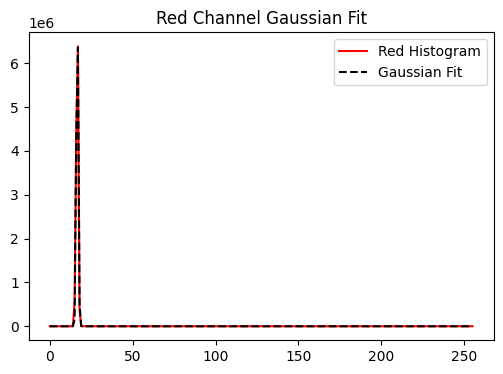

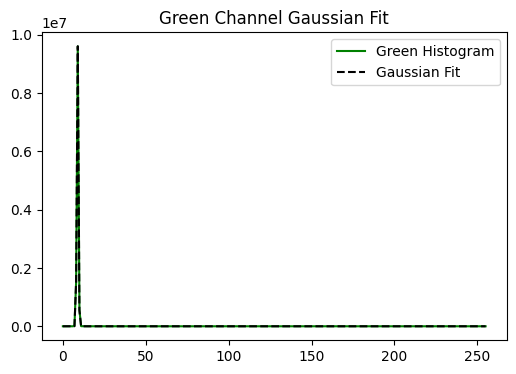

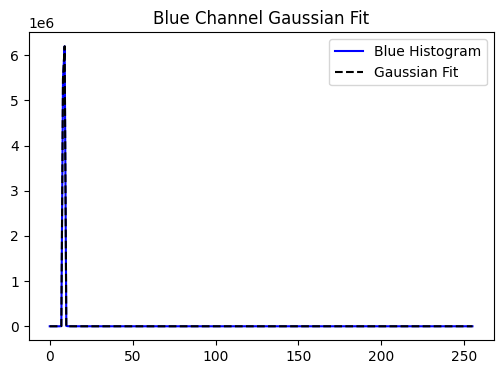

In [86]:
# Plot fit_r against red
plt.figure(figsize=(6, 4))
plt.plot(red, color='red', label='Red Histogram')
if fit_r is not None:
    x = np.arange(len(red))
    amp, mean, std = fit_r
    plt.plot(x, amp * np.exp(-0.5 * ((x - mean) / std)**2), 'k--', label='Gaussian Fit')
plt.title('Red Channel Gaussian Fit')
plt.legend()
plt.show()

# Plot fit_g against green
plt.figure(figsize=(6, 4))
plt.plot(green, color='green', label='Green Histogram')
if fit_g is not None:
    x = np.arange(len(green))
    amp, mean, std = fit_g
    plt.plot(x, amp * np.exp(-0.5 * ((x - mean) / std)**2), 'k--', label='Gaussian Fit')
plt.title('Green Channel Gaussian Fit')
plt.legend()
plt.show()

# Plot fit_b against blue
plt.figure(figsize=(6, 4))
plt.plot(blue, color='blue', label='Blue Histogram')
if fit_b is not None:
    x = np.arange(len(blue))
    amp, mean, std = fit_b
    plt.plot(x, amp * np.exp(-0.5 * ((x - mean) / std)**2), 'k--', label='Gaussian Fit')
plt.title('Blue Channel Gaussian Fit')
plt.legend()
plt.show()

In [21]:
# Alternative 2: Using sklearn for robust fitting
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

def fit_gaussian_sklearn(arr):
    """Fit Gaussian using sklearn's Gaussian Mixture Model"""
    
    # Prepare data for sklearn (needs to be 2D)
    x = np.arange(len(arr))
    # Create weighted data points based on histogram values
    data_points = []
    for i, count in enumerate(arr):
        if count > 0:  # Only include non-zero bins
            # Add multiple copies of the index based on the count
            data_points.extend([i] * min(int(count), 1000))  # Cap to avoid memory issues
    
    if len(data_points) < 10:  # Not enough data
        return None, None
    
    X = np.array(data_points).reshape(-1, 1)
    
    try:
        # Fit Gaussian mixture with 1 component
        gmm = GaussianMixture(n_components=1, random_state=42)
        gmm.fit(X)
        
        mean = gmm.means_[0][0]
        variance = gmm.covariances_[0][0][0]
        stddev = np.sqrt(variance)
        
        # Estimate amplitude from the peak
        amplitude = np.max(arr)
        
        return [amplitude, mean, stddev], None
    except Exception as e:
        print(f"SKlearn fit failed: {e}")
        return None, None

In [22]:
# Alternative 3: Moment-based Gaussian fitting (fastest)
def fit_gaussian_moments(arr):
    """Fit Gaussian using statistical moments - very fast and robust"""
    
    x = np.arange(len(arr))
    y = arr
    
    # Calculate moments
    total = np.sum(y)
    if total == 0:
        return None
    
    # Mean (first moment)
    mean = np.sum(x * y) / total
    
    # Variance (second moment)
    variance = np.sum(((x - mean) ** 2) * y) / total
    stddev = np.sqrt(variance)
    
    # Amplitude (peak value)
    amplitude = np.max(y)
    
    return [amplitude, mean, stddev]

# Alternative 4: Weighted least squares with outlier rejection
from scipy.optimize import least_squares

def fit_gaussian_robust(arr):
    """Robust Gaussian fitting with outlier rejection"""
    
    def gaussian(x, amplitude, mean, stddev, offset):
        return offset + amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)
    
    def residuals(params, x, y, weights):
        return weights * (gaussian(x, *params) - y)
    
    x = np.arange(len(arr))
    y = arr
    
    # Initial parameter estimation
    max_val = np.max(y)
    max_idx = np.argmax(y)
    min_val = np.min(y)
    
    # Estimate width from FWHM
    half_max = (max_val + min_val) / 2
    indices_half_max = np.where(y >= half_max)[0]
    if len(indices_half_max) > 1:
        estimated_width = (indices_half_max[-1] - indices_half_max[0]) / 2.355
    else:
        estimated_width = len(arr) / 10
    
    # Initial guess
    p0 = [max_val - min_val, max_idx, estimated_width, min_val]
    
    # Use weights to reduce influence of outliers
    weights = np.sqrt(np.maximum(y, 1))  # Weight by sqrt of counts
    
    try:
        result = least_squares(residuals, p0, args=(x, y, weights), 
                             bounds=([0, 0, 0.1, 0], 
                                   [np.inf, len(arr), len(arr), np.inf]))
        
        if result.success:
            return result.x
        else:
            return None
    except Exception as e:
        print(f"Robust fit failed: {e}")
        return None

In [23]:
# Test all methods on your data
def test_all_fitting_methods(red, green, blue):
    """Test all Gaussian fitting methods on RGB data"""
    
    methods = {
        'curve_fit': fit_gaussian_curve_fit,
        'sklearn': fit_gaussian_sklearn,
        'moments': fit_gaussian_moments,
        'robust': fit_gaussian_robust
    }
    
    colors = {'red': red, 'green': green, 'blue': blue}
    
    results = {}
    for color_name, data in colors.items():
        print(f"\n--- {color_name.upper()} CHANNEL ---")
        results[color_name] = {}
        
        for method_name, method_func in methods.items():
            try:
                result = method_func(data)
                if result is not None:
                    if isinstance(result, tuple):  # curve_fit returns (params, covariance)
                        params = result[0]
                    else:
                        params = result
                    
                    print(f"{method_name:10}: amp={params[0]:.1f}, mean={params[1]:.1f}, std={params[2]:.1f}")
                    results[color_name][method_name] = params
                else:
                    print(f"{method_name:10}: FAILED")
                    results[color_name][method_name] = None
            except Exception as e:
                print(f"{method_name:10}: ERROR - {e}")
                results[color_name][method_name] = None
    
    return results

In [24]:
# Test all methods on your RGB histogram data
results = test_all_fitting_methods(red, green, blue)


--- RED CHANNEL ---
curve_fit : amp=7802176.6, mean=16.6, std=0.6
sklearn   : amp=6383415.0, mean=21.5, std=13.0
moments   : amp=6383415.0, mean=16.6, std=0.8
robust    : FAILED

--- GREEN CHANNEL ---
curve_fit : amp=9870247.7, mean=8.9, std=0.5
sklearn   : amp=9605866.0, mean=13.3, std=8.6
moments   : amp=9605866.0, mean=8.9, std=0.5
robust    : amp=9866982.3, mean=8.9, std=0.5

--- BLUE CHANNEL ---
curve_fit : amp=13825416.7, mean=8.5, std=0.4
sklearn   : amp=6198324.0, mean=12.9, std=9.1
moments   : amp=6198324.0, mean=8.5, std=0.6
robust    : amp=8390614.6, mean=8.5, std=0.6
curve_fit : amp=13825416.7, mean=8.5, std=0.4
sklearn   : amp=6198324.0, mean=12.9, std=9.1
moments   : amp=6198324.0, mean=8.5, std=0.6
robust    : amp=8390614.6, mean=8.5, std=0.6


In [88]:
# Comparison: curve_fit vs leastsq
print("=== CURVE_FIT vs LEASTSQ COMPARISON ===\n")

# Your original leastsq method (fixed)
def fit_gaussian_leastsq_fixed(arr):
    def gaussian(x, amplitude, mean, stddev, offset=0):
        return offset + amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)  # Fixed formula
    
    def errfunc(p, x, y):
        return gaussian(x, *p) - y
    
    x = np.arange(len(arr))
    y = arr
    
    max_val = np.max(y)
    max_idx = np.argmax(y)
    estimated_width = len(arr) / 10
    p0 = [max_val, max_idx, estimated_width, np.min(y)]
    
    try:
        p1, success = opt.leastsq(errfunc, p0, args=(x, y))
        print(f"  leastsq success code: {success}")
        return p1 if success in [1, 2, 3, 4] else None
    except Exception as e:
        print(f"  leastsq error: {e}")
        return None

# Test both methods on red channel
print("RED CHANNEL:")
print("------------")

# leastsq method
result_leastsq = fit_gaussian_leastsq_fixed(red)
if result_leastsq is not None:
    print(f"leastsq:   amp={result_leastsq[0]:.1f}, mean={result_leastsq[1]:.1f}, std={result_leastsq[2]:.1f}")
else:
    print("leastsq:   FAILED")

# curve_fit method  
result_curve_fit = fit_gaussian_curve_fit(red)
if result_curve_fit is not None:
    print(f"curve_fit: amp={result_curve_fit[0]:.1f}, mean={result_curve_fit[1]:.1f}, std={result_curve_fit[2]:.1f}")
else:
    print("curve_fit: FAILED")

print("\nGREEN CHANNEL:")
print("-------------")

# leastsq method
result_leastsq = fit_gaussian_leastsq_fixed(green)
if result_leastsq is not None:
    print(f"leastsq:   amp={result_leastsq[0]:.1f}, mean={result_leastsq[1]:.1f}, std={result_leastsq[2]:.1f}")
else:
    print("leastsq:   FAILED")

# curve_fit method  
result_curve_fit = fit_gaussian_curve_fit(green)
if result_curve_fit is not None:
    print(f"curve_fit: amp={result_curve_fit[0]:.1f}, mean={result_curve_fit[1]:.1f}, std={result_curve_fit[2]:.1f}")
else:
    print("curve_fit: FAILED")

=== CURVE_FIT vs LEASTSQ COMPARISON ===

RED CHANNEL:
------------
  leastsq success code: 1
leastsq:   amp=7802176.5, mean=16.6, std=0.6
curve_fit: amp=7802176.6, mean=16.6, std=0.6

GREEN CHANNEL:
-------------
  leastsq success code: 3
leastsq:   amp=9870247.7, mean=8.9, std=0.5
curve_fit: amp=9870247.7, mean=8.9, std=0.5


## Why the Offset Parameter is Necessary

The **offset** parameter accounts for the baseline or background level in your data. Without it, you're forcing the Gaussian to go to zero, which rarely matches real data.

=== OFFSET COMPARISON ON RED CHANNEL ===
Without offset: amp=7801257.6, mean=16.6, std=-0.6
With offset:    amp=7802176.5, mean=16.6, std=0.6, offset=1088.6


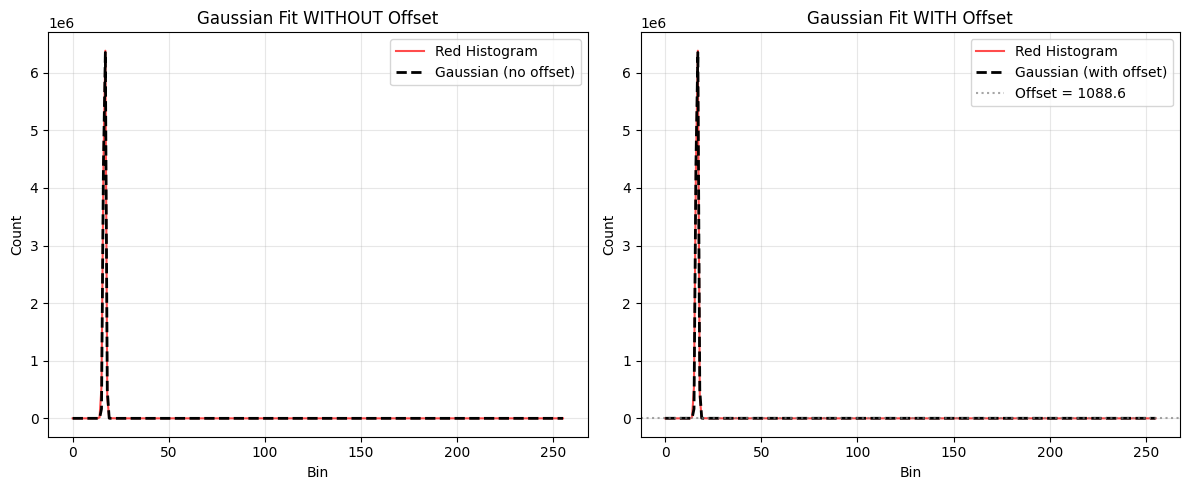


Fit Quality (R²):
Without offset: 0.9971
With offset:    0.9971
Improvement:    0.0000


In [91]:
# Demonstration: Gaussian fitting WITH vs WITHOUT offset
import matplotlib.pyplot as plt

def gaussian_no_offset(x, amplitude, mean, stddev):
    """Gaussian without offset - forces curve to go to zero"""
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)

def gaussian_with_offset(x, amplitude, mean, stddev, offset):
    """Gaussian with offset - allows for baseline"""
    return offset + amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)

def fit_gaussian_no_offset(arr):
    """Fit Gaussian WITHOUT offset parameter"""
    x = np.arange(len(arr))
    y = arr
    
    max_val = np.max(y)
    max_idx = np.argmax(y)
    estimated_width = len(arr) / 10
    p0 = [max_val, max_idx, estimated_width]
    
    try:
        popt, pcov = curve_fit(gaussian_no_offset, x, y, p0=p0, maxfev=5000)
        return popt
    except:
        return None

def fit_gaussian_with_offset(arr):
    """Fit Gaussian WITH offset parameter"""
    x = np.arange(len(arr))
    y = arr
    
    max_val = np.max(y)
    max_idx = np.argmax(y)
    estimated_width = len(arr) / 10
    min_val = np.min(y)
    p0 = [max_val - min_val, max_idx, estimated_width, min_val]
    
    try:
        popt, pcov = curve_fit(gaussian_with_offset, x, y, p0=p0, maxfev=5000)
        return popt
    except:
        return None

# Test on red channel
print("=== OFFSET COMPARISON ON RED CHANNEL ===")

# Fit without offset
fit_no_offset = fit_gaussian_no_offset(red)
if fit_no_offset is not None:
    print(f"Without offset: amp={fit_no_offset[0]:.1f}, mean={fit_no_offset[1]:.1f}, std={fit_no_offset[2]:.1f}")
else:
    print("Without offset: FAILED")

# Fit with offset
fit_with_offset = fit_gaussian_with_offset(red)
if fit_with_offset is not None:
    print(f"With offset:    amp={fit_with_offset[0]:.1f}, mean={fit_with_offset[1]:.1f}, std={fit_with_offset[2]:.1f}, offset={fit_with_offset[3]:.1f}")
else:
    print("With offset: FAILED")

# Plot comparison
plt.figure(figsize=(12, 5))

# Plot 1: Without offset
plt.subplot(1, 2, 1)
x = np.arange(len(red))
plt.plot(red, 'r-', label='Red Histogram', alpha=0.7)
if fit_no_offset is not None:
    fitted_curve = gaussian_no_offset(x, *fit_no_offset)
    plt.plot(x, fitted_curve, 'k--', linewidth=2, label='Gaussian (no offset)')
plt.title('Gaussian Fit WITHOUT Offset')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: With offset
plt.subplot(1, 2, 2)
plt.plot(red, 'r-', label='Red Histogram', alpha=0.7)
if fit_with_offset is not None:
    fitted_curve = gaussian_with_offset(x, *fit_with_offset)
    plt.plot(x, fitted_curve, 'k--', linewidth=2, label='Gaussian (with offset)')
    # Show the offset level
    plt.axhline(y=fit_with_offset[3], color='gray', linestyle=':', alpha=0.7, label=f'Offset = {fit_with_offset[3]:.1f}')
plt.title('Gaussian Fit WITH Offset')
plt.xlabel('Bin')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate fit quality (R-squared)
def calculate_r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)

if fit_no_offset is not None and fit_with_offset is not None:
    y_pred_no_offset = gaussian_no_offset(x, *fit_no_offset)
    y_pred_with_offset = gaussian_with_offset(x, *fit_with_offset)
    
    r2_no_offset = calculate_r_squared(red, y_pred_no_offset)
    r2_with_offset = calculate_r_squared(red, y_pred_with_offset)
    
    print(f"\nFit Quality (R²):")
    print(f"Without offset: {r2_no_offset:.4f}")
    print(f"With offset:    {r2_with_offset:.4f}")
    print(f"Improvement:    {r2_with_offset - r2_no_offset:.4f}")

## Why Offset is Critical in Real Data

### **1. Astronomical Images (like yours)**
- **Dark current**: CCD sensors have baseline noise even in complete darkness
- **Bias level**: Electronic offset added by the camera
- **Sky background**: Light pollution and airglow create a non-zero baseline
- **Read noise**: Random electronic noise creates a floor level

### **2. Other Real-World Examples**
- **Spectroscopy**: Detector has baseline response
- **Chromatography**: Solvent peak creates baseline
- **Medical imaging**: Background tissue signal
- **Signal processing**: DC offset in electronic signals

### **3. Mathematical Impact**
Without offset, you're fitting: `y = A × exp(-0.5×((x-μ)/σ)²)`
With offset, you're fitting: `y = offset + A × exp(-0.5×((x-μ)/σ)²)`

The offset allows the curve to have a **realistic baseline**, which almost always exists in real data.

=== WHY GREEN/BLUE CHANNELS FAIL WITHOUT OFFSET ===

Baseline (minimum) values:
Red:   0
Green: 0
Blue:  0

Peak (maximum) values:
Red:   6383415
Green: 9605866
Blue:  6198324

Signal-to-baseline ratio:
Red:   6383415.0
Green: 9605866.0
Blue:  6198324.0

=== FITTING WITHOUT OFFSET ===
Red  : SUCCESS - amp=7801257.6, mean=16.6, std=-0.6
Green: SUCCESS - amp=9870286.2, mean=8.9, std=-0.5
Blue : SUCCESS - amp=13819062.5, mean=8.5, std=-0.4

=== FITTING WITH OFFSET ===
Red  : SUCCESS - amp=7802176.5, mean=16.6, std=0.6, offset=1088.6
Green: SUCCESS - amp=9870247.7, mean=8.9, std=0.5, offset=71.1
Blue : SUCCESS - amp=13825416.7, mean=8.5, std=0.4, offset=22.9


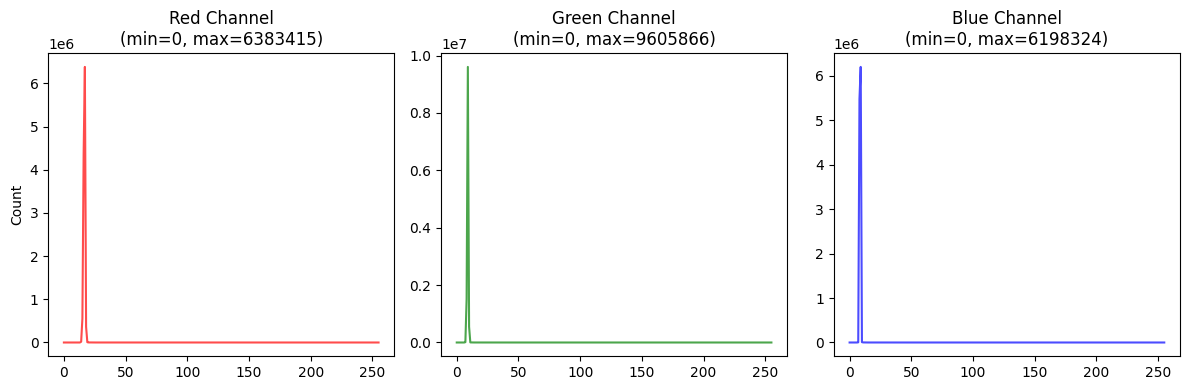

In [92]:
# Let's see why green and blue channels specifically need offset
print("=== WHY GREEN/BLUE CHANNELS FAIL WITHOUT OFFSET ===\n")

# Check baseline levels for each channel
red_min = np.min(red)
green_min = np.min(green)
blue_min = np.min(blue)

red_max = np.max(red)
green_max = np.max(green)
blue_max = np.max(blue)

print("Baseline (minimum) values:")
print(f"Red:   {red_min}")
print(f"Green: {green_min}")
print(f"Blue:  {blue_min}")

print(f"\nPeak (maximum) values:")
print(f"Red:   {red_max}")
print(f"Green: {green_max}")
print(f"Blue:  {blue_max}")

print(f"\nSignal-to-baseline ratio:")
print(f"Red:   {red_max/max(red_min, 1):.1f}")
print(f"Green: {green_max/max(green_min, 1):.1f}")
print(f"Blue:  {blue_max/max(blue_min, 1):.1f}")

# Test fitting without offset on all channels
print(f"\n=== FITTING WITHOUT OFFSET ===")
for color_name, data in [('Red', red), ('Green', green), ('Blue', blue)]:
    fit_result = fit_gaussian_no_offset(data)
    if fit_result is not None:
        print(f"{color_name:5}: SUCCESS - amp={fit_result[0]:.1f}, mean={fit_result[1]:.1f}, std={fit_result[2]:.1f}")
    else:
        print(f"{color_name:5}: FAILED")

print(f"\n=== FITTING WITH OFFSET ===")
for color_name, data in [('Red', red), ('Green', green), ('Blue', blue)]:
    fit_result = fit_gaussian_with_offset(data)
    if fit_result is not None:
        print(f"{color_name:5}: SUCCESS - amp={fit_result[0]:.1f}, mean={fit_result[1]:.1f}, std={fit_result[2]:.1f}, offset={fit_result[3]:.1f}")
    else:
        print(f"{color_name:5}: FAILED")

# Show the problem visually for green channel
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(red, 'r-', alpha=0.7)
plt.title(f'Red Channel\n(min={red_min}, max={red_max})')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.plot(green, 'g-', alpha=0.7)
plt.title(f'Green Channel\n(min={green_min}, max={green_max})')

plt.subplot(1, 3, 3)
plt.plot(blue, 'b-', alpha=0.7)
plt.title(f'Blue Channel\n(min={blue_min}, max={blue_max})')

plt.tight_layout()
plt.show()